In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
# load the dataset
def load_dataset(filename, cramer_coef, target, var_count, row_count):
    # load the dataset as a pandas DataFrame
    df = pd.read_csv(filename, header=0, index_col=0, nrows=row_count)
    
    # split into input (X) and output (y) variables
    X = df.drop(target, axis=1, inplace=False)
    
    # order columns by Cramer coeffs
    cramer_df = pd.read_csv(cramer_coef, sep='\t', header=None)
    cols = cramer_df.iloc[:, 0].tolist()
    X = X[cols]
    
    # Reduce # of variables
    if var_count < X.shape[1]:
        X = X.iloc[:, 0:var_count]
        
    y = df[target]
    
    # reshape target to be a 2d array
    #y = y.reshape((len(y), 1))
    #X = X.values
    
    return X, y

In [3]:
from sklearn.preprocessing import LabelEncoder
def encode_df(df):
    df_enc = pd.DataFrame()
    for col in df:
        le = LabelEncoder()
        le.fit(df[col])
        df_enc[col] = le.transform(df[col])
    return df_enc

In [4]:
# prepare input data
from sklearn.preprocessing import LabelEncoder
def prepare_inputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        #le.fit(X_train[:, i])
        # Fix missing field error by fitting both train & test - MWB
        both = np.concatenate((X_train[:, i], X_test[:,i]), axis=0)
        le.fit(both)  
        # encode
        train_enc = le.transform(X_train[:, i])
        test_enc = le.transform(X_test[:, i])
        
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc

In [5]:
# MWB - Not necessary - already [0,1]
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [6]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
#np.set_printoptions(threshold=1000)
np.set_printoptions(edgeitems=1000, threshold=np.inf)

In [14]:
# When running on lhc-lx-mbopf to limit cores used

# THROWS: 
#     AttributeError: module 'tensorflow.keras.backend' has no attribute 'set_session'

#import tensorflow as tf
#import tensorflow.keras.backend as K
#K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=7, inter_op_parallelism_threads=7)))

In [15]:
# example of learned embedding encoding for a neural network
from numpy import unique
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers.merge import concatenate
#from keras.utils import plot_model  MWB - errors
#from prettytable import PrettyTable
#from tabulate import tabulate
 
# load the dataset
X, y = load_dataset('../../../data/csl/CSL_tl_PI_binned.csv', 
                    '../../../data/csl/CramerTheil/Cramer_PI_Tl_vars_Union50.csv',
                    'trans_loss', 200, 200000)
print(X.shape)
y.value_counts()

(185413, 66)


0    175069
1     10344
Name: trans_loss, dtype: int64

In [16]:
# Encode features using LabelEncoder
X_enc_df = encode_df(X)

#for col in X_enc_df:
#    print(unique(X_enc_df[col]))

In [17]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_enc_df, y, stratify=y, test_size=0.30, random_state=1)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(129789, 66)
(129789,)
0    122548
1      7241
Name: trans_loss, dtype: int64


In [19]:
from imblearn.over_sampling import RandomOverSampler
#from stat_mwb import under_samp

#X_res, y_res = under_samp(X_train_enc, y_train_enc)
sampler = RandomOverSampler(sampling_strategy=1.0)
X_train, y_train= sampler.fit_resample(X_train, y_train)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(245096, 66)
(245096,)
0    122548
1    122548
Name: trans_loss, dtype: int64


In [21]:
X_train_enc = np.array(X_train)
X_test_enc = np.array(X_test)
y_train_enc = np.array(y_train)
y_test_enc = np.array(y_test)

In [22]:
# make output 3d
y_train_enc = y_train_enc.reshape((len(y_train_enc), 1, 1))
y_test_enc = y_test_enc.reshape((len(y_test_enc), 1, 1))
# prepare each input head
print(y_train_enc.shape)

(245096, 1, 1)


In [23]:
X_train_enc.shape

(245096, 66)

In [24]:
in_layers = list()
em_layers = list()
for col in range(X_train_enc.shape[1]):
    # calculate the number of unique inputs
    n_labels = len(unique(X_train_enc[:, col]))
    # define input layer
    in_layer = Input(shape=(1,))
    # define embedding layer
    em_layer = Embedding(n_labels+1, 10)(in_layer)  # MWB - Embedding docs say to use this
    #em_layer = Embedding(n_labels, 10)(in_layer)
    # store layers
    in_layers.append(in_layer)
    em_layers.append(em_layer)

In [25]:
# transpose input data to lists
X_train_encl = []
X_test_encl = []
for col in range(X_train_enc.shape[1]):
    X_train_encl.append(X_train_enc[..., [col]])
    X_test_encl.append(X_test_enc[..., [col]])
X_train_encl[0].shape

(245096, 1)

In [26]:
#for col in range(X_test_enc.shape[1]):
#    print(unique(X_test_enc[:,col]))

In [27]:
print(len(in_layers))
print(len(em_layers))
print(type(em_layers))
print(type(X_train_encl))

66
66
<class 'list'>
<class 'list'>


In [28]:
%%time
# concat all embeddings
from keras.metrics import AUC
BATCH_SIZE = 16
merge = concatenate(em_layers)
dense = Dense(10, activation='relu', kernel_initializer='he_normal')(merge)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=in_layers, outputs=output)
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', sample_weight_mode='temporal', 
              metrics=['accuracy','Precision','Recall','AUC',
                       AUC(name='pr_auc', curve='PR')])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# plot graph: MWB - Requires pydot and graphviz (which wants python 3.9)
#plot_model(model, show_shapes=True, to_file='embeddings.png')

#weights = {0:0.51, 1:18.0}
#weights = {0:1, 1:36}
#weights = np.zeros((10, 2))
#weights[:,0] = 0.51
#weights[:,1] = 18.0 
#print(type(weights))
#print(weights)

# fit the keras model on the dataset
run_start = time.time()
model.fit(X_train_encl, y_train_enc, epochs=20, batch_size=BATCH_SIZE, verbose=2) 
#model.fit(X_train_encl, y_train_enc, epochs=20, batch_size=16, verbose=2, 
#          class_weight=weights)
# evaluate the keras model
_, accuracy, prec, recall, auc, pr_auc = model.evaluate(X_test_encl, y_test_enc, verbose=0)
#_, accuracy, prec, recall, auc = model.evaluate(X_test_enc, y_test_enc, verbose=0)
#print('Accuracy: %.2f' % (accuracy*100))
print(f'Accuracy: {accuracy}; Prec: {prec}; Recall: {recall}, ROC_AUC: {auc}, PR_AUC: {pr_auc}')

Epoch 1/20
15319/15319 - 240s - loss: 0.4793 - accuracy: 0.7724 - precision: 0.7237 - recall: 0.8814 - auc: 0.8345 - pr_auc: 0.7968
Epoch 2/20
15319/15319 - 221s - loss: 0.4631 - accuracy: 0.7803 - precision: 0.7269 - recall: 0.8980 - auc: 0.8448 - pr_auc: 0.8096
Epoch 3/20
15319/15319 - 233s - loss: 0.4550 - accuracy: 0.7846 - precision: 0.7314 - recall: 0.8998 - auc: 0.8508 - pr_auc: 0.8161
Epoch 4/20
15319/15319 - 235s - loss: 0.4482 - accuracy: 0.7879 - precision: 0.7353 - recall: 0.8997 - auc: 0.8558 - pr_auc: 0.8213
Epoch 5/20
15319/15319 - 222s - loss: 0.4435 - accuracy: 0.7905 - precision: 0.7380 - recall: 0.9007 - auc: 0.8586 - pr_auc: 0.8242
Epoch 6/20
15319/15319 - 225s - loss: 0.4395 - accuracy: 0.7924 - precision: 0.7405 - recall: 0.9001 - auc: 0.8610 - pr_auc: 0.8268
Epoch 7/20
15319/15319 - 220s - loss: 0.4367 - accuracy: 0.7942 - precision: 0.7421 - recall: 0.9019 - auc: 0.8629 - pr_auc: 0.8284
Epoch 8/20
15319/15319 - 216s - loss: 0.4342 - accuracy: 0.7961 - precision:

In [39]:
predictions = model.predict(X_test_encl, batch_size=BATCH_SIZE)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [46]:
from sklearn.metrics import precision_recall_curve
prob1 = predictions.flatten()
print(len(prob1))
print(len(y_test))
prec_all, recall_all, pr_thresh = precision_recall_curve(y_test, prob1)
prec_all
print(len(prec_all))
print(len(recall_all))
print(len(pr_thresh))

55624
55624
52862
52862
52861


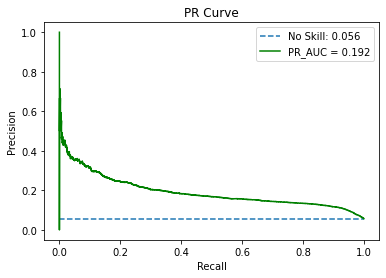

In [49]:
import matplotlib.pyplot as plt
import sklearn.metrics
%matplotlib inline
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle= '--', label= f'No Skill: {no_skill:.3f}')

pr_auc = sklearn.metrics.auc(recall_all, prec_all)
plt.title('PR Curve')
plt.plot(recall_all, prec_all, 'g', label = 'PR_AUC = %0.3f' % pr_auc)
plt.legend(loc = 'upper right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [30]:
print(type(predictions))
print(len(predictions))
print(len(X_test_encl))

<class 'numpy.ndarray'>
55624
66


In [31]:
print(np.bincount(y_test_enc.flatten()))
print(np.bincount(predictions.flatten() > 0.5))

[52521  3103]
[36808 18816]


In [32]:
y_true = y_test_enc.flatten()
y_pred = predictions.flatten() > 0.5

In [33]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, fbeta_score
ntn, nfp, nfn, ntp = (confusion_matrix(y_true, y_pred, normalize='all').flatten()*10000).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
total = tn + fp + fn + tp
acc = (tn + tp)/total
spec = tn / (tn + fp)
mcc = matthews_corrcoef(y_true, y_pred)
f2 = fbeta_score(y_true, y_pred, beta=2.0, average=None)
print(ntn, nfp, nfn, ntp)
print(f'acc = {acc}')
print(f'prec = {prec}')
print(f'recall = {recall}')
print(f'spec = {spec}')
print(f'auc = {auc}')
print(f'mcc = {mcc}')
print(f'f2 = {f2[1]}')

6511 2930 105 452
acc = 0.6964439810153891
prec = 0.13376913964748383
recall = 0.8111504912376404
spec = 0.6896669903467184
auc = 0.8131365776062012
mcc = 0.2429417222102656
f2 = 0.403003714615089


In [34]:
len(y_true)

55624

In [37]:
from sklearn.metrics import accuracy_score
y_test = y_true
print(f'np.bincount(y_test) =\n {np.bincount(y_test)}')
print(f'np.bincount(y_pred) =\n {np.bincount(y_pred)}')
accuracy_s = accuracy_score(y_test, y_pred)
accuracy_s
probs = model.pr

np.bincount(y_test) =
 [52521  3103]
np.bincount(y_pred) =
 [36808 18816]


0.6964439810153891

In [ ]:
def create_outfile_base(opts, params_dict=None):
    import datetime
    now = datetime.datetime.now()
    timestamp = str(now.strftime("%Y%m%d_%H%M%S"))
    if params_dict:
        param_str = "_".join([x if isinstance(x, str) else str(x) for x in params_dict.values()])
        fname = "-".join([opts.target, opts.period, opts.feats, opts.under_alg, opts.pred_alg, param_str,\
                          str(opts.seed), str(opts.samp_strat), timestamp])
    else:
        fname = "-".join([opts.target, opts.period, opts.feats, opts.under_alg, opts.pred_alg, str(opts.seed), timestamp])
    fname = fname.replace(" ", "")
    return opts.output_dir + '/' + fname